# Kaggle Competition: Natural Language Processing with Disaster Tweets
**Using machine learning to classify Tweets as either true or fake** 

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import spacy
from spacy_cleaner import processing, Cleaner

## Loading in the training data

In [24]:
train_data = pd.read_csv('raw_data/train.csv', index_col='id')

In [25]:
train_data.head(3)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [26]:
train_data.shape

(7613, 4)

## Data Cleaning and Feature Selection

In [27]:
train_data.isna().sum()/train_data.shape[0]

keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [28]:
train_data.nunique()

keyword      221
location    3341
text        7503
target         2
dtype: int64

The dataset is missing ~0.8% of values in the keyword column and around 33% of values in the location column. My plan is to drop the location column, and replace NaN in keywords with a "None" placeholder. 

In [29]:
train_data.drop(columns=['location'], inplace=True)

In [30]:
train_data.isna().sum()

keyword    61
text        0
target      0
dtype: int64

In [31]:
train_data['keyword'] = train_data['keyword'].replace(np.nan, 'None')

In [32]:
train_data.isna().sum()

keyword    0
text       0
target     0
dtype: int64

Drop duplicates.

In [33]:
train_data.drop_duplicates(inplace=True)

### I will encode the keyword column later in a pipeline so it can be passed to the model.

Let's check the distribution of targets in the dataset.

Text(0.5, 1.0, 'Target Distribution')

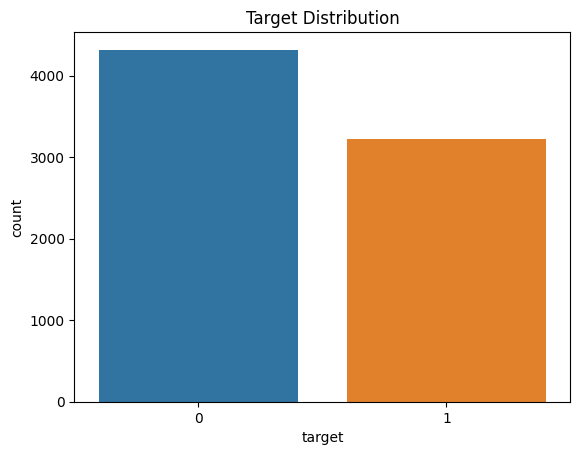

In [34]:
sns.countplot(data=train_data, x='target')
plt.title('Target Distribution')

In [35]:
train_data['target'].value_counts(normalize=True)

0    0.57247
1    0.42753
Name: target, dtype: float64

The target seems fairly well balanced for this datset.

In [36]:
train_data.shape

(7541, 3)

Let's cleanup the text column next.   
I will use Spacy-Cleaner to do this.

In [51]:
model = spacy.load('en_core_web_sm')

In [52]:
cleaner = Cleaner(
    model,
    # remove stopwords
    processing.remove_stopword_token,
    # remove any urls
    processing.remove_url_token,
    # remove any email addresses
    processing.remove_email_token,
    # remove punctuation
    processing.remove_punctuation_token,
    # remove numbers
    processing.remove_number_token,
    # lemmatize the text
    processing.mutate_lemma_token,
)

In [65]:
test = train_data.iloc[0]['text']
cleaned = cleaner.clean([test])
cleaned[0].lower()

Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00, 58.47it/s]


'deed reason earthquake allah forgive'

In [66]:
test

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [68]:
cleaned_tweets = cleaner.clean(train_data['text'])
type(cleaned_tweets)

Cleaning Progress: 100%|██████████| 7541/7541 [00:22<00:00, 340.43it/s]


list

In [70]:
cleaned_tweets = [tweet.lower() for tweet in cleaned_tweets]

In [72]:
train_data['cleaned_text'] = cleaned_tweets
train_data.drop(columns=['text'], inplace=True)
train_data.head()

,keyword,target,cleaned_text
id,,,
1,None,1,deed reason earthquake allah forgive
4,None,1,forest fire near la ronge sask canada
5,None,1,resident ask shelter place notify officer evac...
6,None,1,people receive wildfire evacuation order calif...
7,None,1,get send photo ruby alaska smoke wildfire pour...


## TFIDF Vectorize the Cleaned Text, OneHotEncode the Keyword Features

In [86]:
X = train_data[['keyword', 'cleaned_text']]
y = train_data['target']
X.head()

,keyword,cleaned_text
id,,
1,None,deed reason earthquake allah forgive
4,None,forest fire near la ronge sask canada
5,None,resident ask shelter place notify officer evac...
6,None,people receive wildfire evacuation order calif...
7,None,get send photo ruby alaska smoke wildfire pour...


In [88]:
print(X.shape)
print(y.shape)

(7541, 2)
(7541,)


In [89]:
print(X['keyword'].nunique())

222


I have a slight concern that this one hot encoding is introducing too many dimensions to the data, but I'll go with it.

In [92]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['keyword']),
    (TfidfVectorizer(), 'cleaned_text')
)

In [93]:
transformer

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(), ['keyword']),
                                ('tfidfvectorizer', TfidfVectorizer(),
                                 'cleaned_text')])

In [94]:
X = transformer.fit_transform(X)
X.shape

(7541, 15181)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6032, 15181)
(6032,)
(1509, 15181)
(1509,)


# Now that the features have been prepared, let's train a few models and compare the results.

In [140]:
model_dict = {
    'MultiNB': MultinomialNB(),
    'BernNB':BernoulliNB(),
    'RandomForest':RandomForestClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'DecisionTree':DecisionTreeClassifier(),
    'LogReg':LogisticRegression(),
    'XGB':XGBClassifier()
}

accuracy_dict = {}
f1_dict = {}

In [141]:
for name, model in model_dict.items():
    print(f'Working on {name} model...')
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_dict.update({name:acc})
    f1 = f1_score(pred, y_test)
    f1_dict.update({name: f1})


Working on MultiNB model...
Working on BernNB model...
Working on RandomForest model...
Working on AdaBoost model...
Working on DecisionTree model...
Working on LogReg model...
Working on XGB model...


In [142]:
accuracy_dict

{'MultiNB': 0.7859509609012592,
 'BernNB': 0.8071570576540755,
 'RandomForest': 0.7925778661365143,
 'AdaBoost': 0.7607687210072896,
 'DecisionTree': 0.7369118621603711,
 'LogReg': 0.7879390324718356,
 'XGB': 0.7726971504307488}

In [143]:
f1_dict

{'MultiNB': 0.7345932621199671,
 'BernNB': 0.7523404255319148,
 'RandomForest': 0.7237422771403355,
 'AdaBoost': 0.6773905272564791,
 'DecisionTree': 0.689601250977326,
 'LogReg': 0.7324414715719063,
 'XGB': 0.6940231935771632}

Text(0.5, 1.0, 'Accuracy Scores of Models')

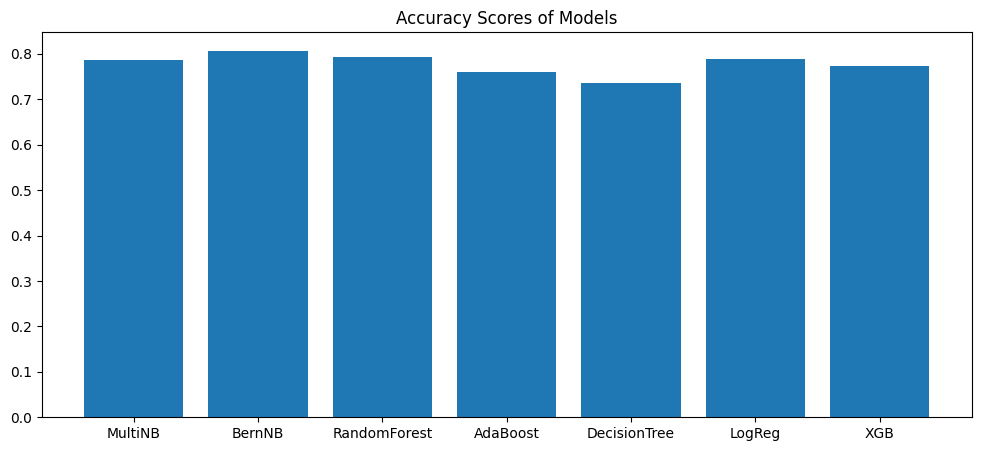

In [144]:
plt.figure(figsize=(12,5))
plt.bar(accuracy_dict.keys(), accuracy_dict.values())
plt.title('Accuracy Scores of Models')

Text(0.5, 1.0, 'F1 Scores of Models')

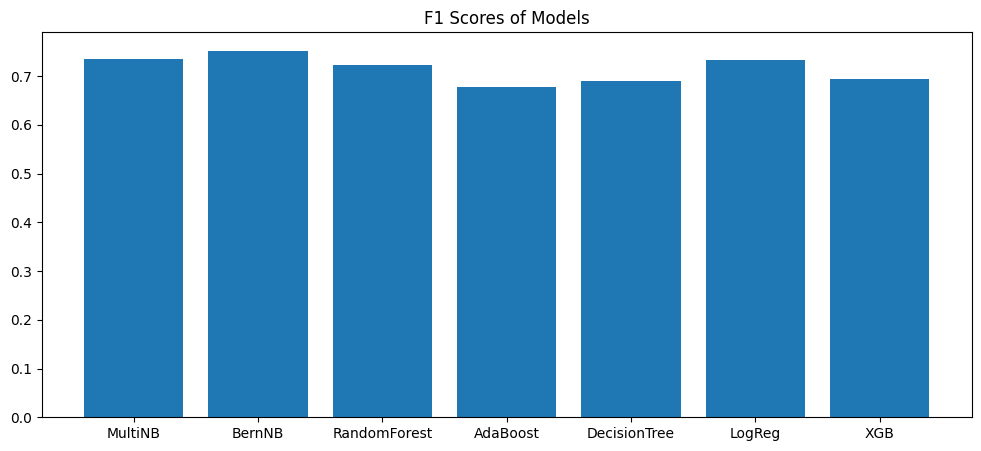

In [145]:
plt.figure(figsize=(12,5))
plt.bar(f1_dict.keys(), f1_dict.values())
plt.title('F1 Scores of Models')

# It seems that the Bernouilli Naive Bayes model had the highest F1 score, which is the metric used in this competition. Let's use it to make a Kaggle submission.

In [120]:
test_df = pd.read_csv('raw_data/test.csv', index_col='id')
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Initialize the submission df.

In [121]:
submit_df = pd.DataFrame()
submit_df['id'] = test_df.index
submit_df.head()

,id
0,0
1,2
2,3
3,9
4,11


# Now we need to prepare the data just like we did before.
- Drop location column
- Replace NaN keywords with a "None" placeholder string.
- Clean the text using spacy_cleaner, then make all lowercase
- Encode the keyword column using OneHotEncoder (using column_transformer)
- Vectorize the text column using TfidfVectorizer (using column_transformer)

In [122]:
test_df.isna().sum()

keyword       26
location    1105
text           0
dtype: int64

In [123]:
test_df.drop(columns=['location'], inplace=True)

In [124]:
test_df['keyword'] = test_df['keyword'].replace(np.nan, 'None')

In [125]:
test_df.isna().sum()

keyword    0
text       0
dtype: int64

In [126]:
cleaned_test_tweets = cleaner.clean(test_df['text'])

Cleaning Progress: 100%|██████████| 3263/3263 [00:09<00:00, 332.78it/s]


In [127]:
cleaned_test_tweets = [tweet.lower() for tweet in cleaned_test_tweets]

In [128]:
test_df['text'] = cleaned_test_tweets

In [129]:
test_df.head()

,keyword,text
id,,
0,None,happen terrible car crash
2,None,hear earthquake different city stay safe
3,None,forest fire spot pond geese flee street save
9,None,apocalypse lighting spokane wildfire
11,None,typhoon soudelor kill china taiwan


In [130]:
test_df.rename(columns={'keyword': 'keyword', 'text': 'cleaned_text'}, inplace=True)
test_df.head()

,keyword,cleaned_text
id,,
0,None,happen terrible car crash
2,None,hear earthquake different city stay safe
3,None,forest fire spot pond geese flee street save
9,None,apocalypse lighting spokane wildfire
11,None,typhoon soudelor kill china taiwan


In [133]:
X_sub = transformer.transform(test_df)
X_sub.shape

(3263, 15181)

In [134]:
BNB = BernoulliNB()
BNB

BernoulliNB()

In [135]:
BNB.fit(X, y)

BernoulliNB()

In [136]:
sub_pred = BNB.predict(X_sub)
sub_pred.shape

(3263,)

In [137]:
submit_df['target'] = sub_pred
submit_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Write the dataframe to a CSV file and submit!

In [138]:
submit_df.to_csv('submission.csv', index=False)

This particular model resulted in an F1 score of 0.79773 on Kaggle.